In [25]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

# Modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Cleaned Dataset
df = pd.read_csv("cleaned_fire_response_data.csv")
print("Shape:", df.shape)
df.head()

Shape: (101672, 36)


,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Analysis Neighborhoods,response_time,hour,day_of_week,month,Call Type (Grouped)
0,160943727,53,16037460,Medical Incident,04/03/2016,04/03/2016,2016-04-03 23:15:12,04/03/2016 11:18:05 PM,04/03/2016 11:18:33 PM,04/03/2016 11:18:45 PM,...,2.0,4.0,6.0,Tenderloin,36.0,19.966667,23,Sunday,4,Medical Incident
1,161021964,AM14,16040565,Medical Incident,04/11/2016,04/11/2016,2016-04-11 13:14:47,04/11/2016 01:19:53 PM,04/11/2016 01:20:42 PM,04/11/2016 01:21:06 PM,...,1.0,2.0,9.0,Mission,20.0,13.016667,13,Monday,4,Medical Incident
2,160931745,E03,16036856,Medical Incident,04/02/2016,04/02/2016,2016-04-02 13:08:02,04/02/2016 01:09:44 PM,04/02/2016 01:10:16 PM,04/02/2016 01:13:09 PM,...,2.0,2.0,6.0,Tenderloin,36.0,7.083333,13,Saturday,4,Medical Incident
3,160921757,E09,16036446,Medical Incident,04/01/2016,04/01/2016,2016-04-01 13:20:24,04/01/2016 01:21:15 PM,04/01/2016 01:21:31 PM,04/01/2016 01:23:44 PM,...,1.0,10.0,10.0,Bayview Hunters Point,1.0,5.600000,13,Friday,4,Medical Incident
4,160991136,T14,16039249,Outside Fire,04/08/2016,04/08/2016,2016-04-08 10:28:58,04/08/2016 10:29:28 AM,04/08/2016 10:38:28 AM,04/08/2016 10:38:28 AM,...,2.0,7.0,7.0,Golden Gate Park,12.0,9.500000,10,Friday,4,Outside Fire


In [7]:
# Target
target = "response_time"

# Candidate features
categorical_features = [
    "Call Type (Grouped)",
    "Unit Type",
    "Priority",
    "day_of_week",
    "month",
    "hour",
    "Station Area",
    "Zipcode of Incident"
]

# Drop rows where any selected categorical features are missing (if any)
df = df.dropna(subset=categorical_features)

# Feature matrix and target
X = df[categorical_features]
y = df[target]

In [11]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features)]
)

In [13]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

Train set: (81270, 8)
Test set: (20318, 8)


In [19]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:\n  RMSE = {rmse:.2f}\n  R² = {r2:.3f}")
    return {"Model": name, "RMSE": rmse, "R2": r2}

# Dummy baseline
dummy_pipeline = make_pipeline(preprocessor, DummyRegressor(strategy="mean"))
dummy_pipeline.fit(X_train, y_train)
results = [evaluate_model("Dummy Regressor", dummy_pipeline, X_train, X_test, y_train, y_test)]

Dummy Regressor:
  RMSE = 5.69
  R² = -0.000


In [21]:
linreg_pipeline = make_pipeline(preprocessor, LinearRegression())
linreg_pipeline.fit(X_train, y_train)
results.append(evaluate_model("Linear Regression", linreg_pipeline, X_train, X_test, y_train, y_test))

Linear Regression:
  RMSE = 4.77
  R² = 0.297


In [23]:
ridge_params = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}
ridge_pipeline = make_pipeline(preprocessor, Ridge())
ridge_cv = GridSearchCV(ridge_pipeline, param_grid=ridge_params, cv=5, scoring="neg_root_mean_squared_error")
ridge_cv.fit(X_train, y_train)

# Best model
best_ridge = ridge_cv.best_estimator_
results.append(evaluate_model("Ridge Regression", best_ridge, X_train, X_test, y_train, y_test))
print("Best Ridge alpha:", ridge_cv.best_params_)

Ridge Regression:
  RMSE = 4.77
  R² = 0.297
Best Ridge alpha: {'ridge__alpha': 1}


In [29]:
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
))
rf_pipeline.fit(X_train, y_train)
results.append(evaluate_model("Random Forest", rf_pipeline, X_train, X_test, y_train, y_test))

Random Forest:
  RMSE = 4.71
  R² = 0.315


In [31]:
gbr_pipeline = make_pipeline(preprocessor, GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
))
gbr_pipeline.fit(X_train, y_train)
results.append(evaluate_model("Gradient Boosting", gbr_pipeline, X_train, X_test, y_train, y_test))

Gradient Boosting:
  RMSE = 4.68
  R² = 0.324


In [33]:
# Use a 10k sample from training set
sample_idx = np.random.choice(X_train.shape[0], size=10000, replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

knn_pipeline = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=5))
knn_pipeline.fit(X_sample, y_sample)
results.append(evaluate_model("KNN (sampled)", knn_pipeline, X_train, X_test, y_train, y_test))

KNN (sampled):
  RMSE = 5.18
  R² = 0.173


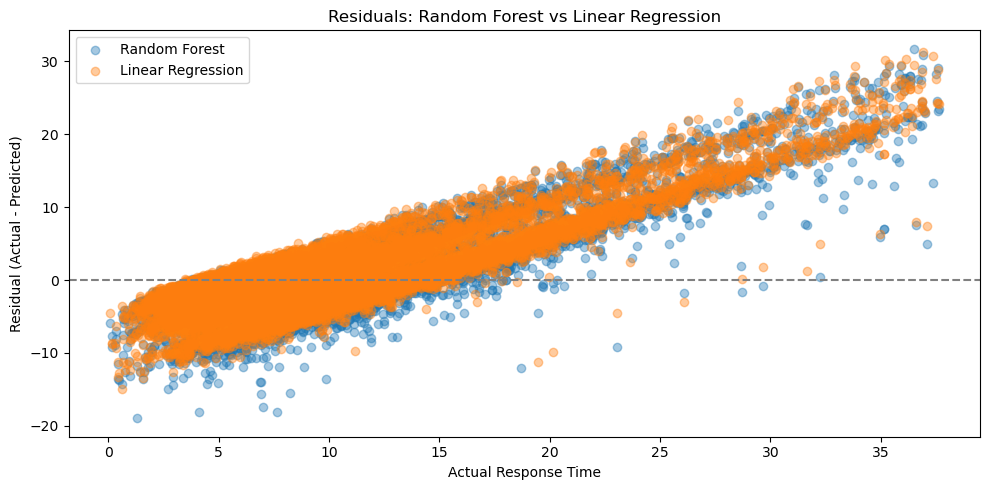

In [39]:
# Predict using original fitted pipelines (do NOT manually transform X_test)
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_lin = linreg_pipeline.predict(X_test)

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test - y_pred_rf, alpha=0.4, label="Random Forest")
plt.scatter(y_test, y_test - y_pred_lin, alpha=0.4, label="Linear Regression")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Actual Response Time")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals: Random Forest vs Linear Regression")
plt.legend()
plt.tight_layout()
plt.show()

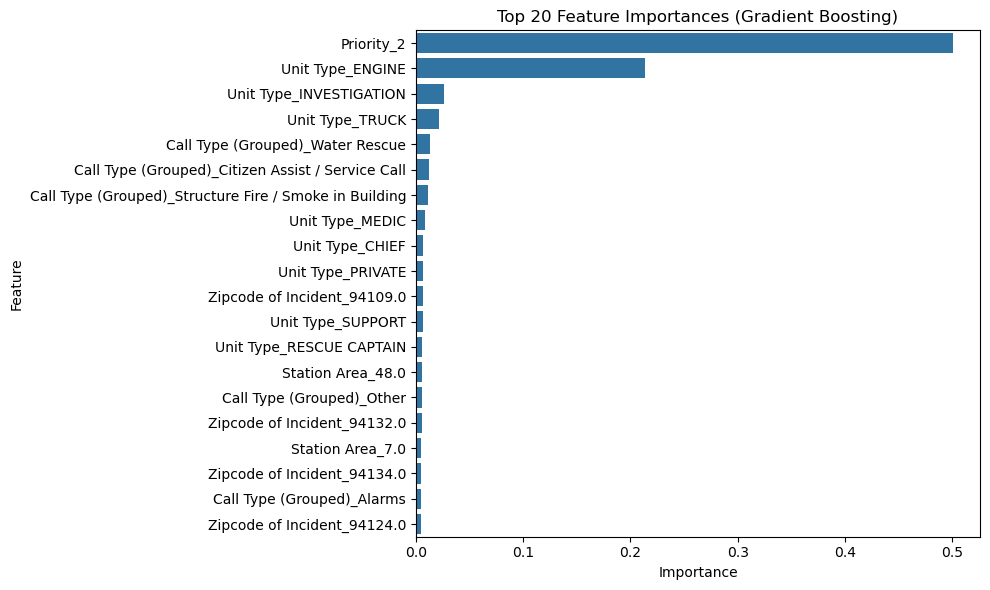

In [45]:
# Extract fitted OneHotEncoder from the pipeline
onehot = gbr_pipeline.named_steps['columntransformer'].named_transformers_['cat']['onehot']
feature_names = onehot.get_feature_names_out(categorical_features)

# Extract the GradientBoostingRegressor and transformed features
gbr_model = gbr_pipeline.named_steps['gradientboostingregressor']
X_train_enc = gbr_pipeline.named_steps['columntransformer'].transform(X_train)

# Get feature importances
importances = gbr_model.feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Top 20 Feature Importances (Gradient Boosting)")
plt.tight_layout()
plt.show()


In [43]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)

,Model,RMSE,R2
0,Gradient Boosting,4.679381,0.324438
1,Random Forest,4.713074,0.314674
2,Ridge Regression,4.772730,0.297215
3,Linear Regression,4.773254,0.297061
4,KNN (sampled),5.178146,0.172749
5,Dummy Regressor,5.693461,-0.000095
